In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:

print("*" * 70)
print("SECTION 1: DATASET CREATION")
print("*" * 70)

# Create synthetic dataset with 5 classes
samples_count = 2000
features_count = 20
informative_features = 15
classes_count = 5

features, targets = make_classification(
    n_samples=samples_count,
    n_features=features_count,
    n_informative=informative_features,
    n_classes=classes_count,
    n_clusters_per_class=1,
    random_state=RANDOM_SEED
)
# Convert labels to one-hot encoding
def convert_to_onehot(labels, num_classes):
    """Transform class labels into one-hot encoded vectors"""
    encoded = np.zeros((labels.shape[0], num_classes))
    encoded[np.arange(labels.shape[0]), labels] = 1
    return encoded

targets_encoded = convert_to_onehot(targets, classes_count)

# Split data into training and testing sets
features_train, features_test, targets_train, targets_test, labels_train, labels_test = train_test_split(
    features, targets_encoded, targets,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=targets
)

print(f"Total samples: {features.shape[0]}")
print(f"Input features: {features.shape[1]}")
print(f"Output classes: {classes_count}")
print(f"Training set: {len(features_train)} samples")
print(f"Testing set: {len(features_test)} samples\n")

**********************************************************************
SECTION 1: DATASET CREATION
**********************************************************************
Total samples: 2000
Input features: 20
Output classes: 5
Training set: 1600 samples
Testing set: 400 samples



In [ ]:
# ============================================================================
# SECTION 2: NEURAL NETWORK IMPLEMENTATION
# ============================================================================

class MultiLayerPerceptron:
    """
    Three-Layer Hidden Neural Network for Multi-Class Classification

    Network Structure:
    - Input Layer: Variable size based on features
    - Hidden Layer 1: 64 neurons, ReLU activation
    - Hidden Layer 2: 32 neurons, ReLU activation
    - Hidden Layer 3: 16 neurons, ReLU activation
    - Output Layer: 5 neurons, Softmax activation

    Training: Gradient Descent with Backpropagation
    Loss: Categorical Cross-Entropy
    """

    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        """Initialize network parameters"""
        self.learning_rate = learning_rate

        # Layer 1: Input to Hidden1 (64 neurons)
        self.weights_layer1 = np.random.randn(input_dim, 64) * np.sqrt(2.0 / input_dim)
        self.bias_layer1 = np.zeros((1, 64))

        # Layer 2: Hidden1 to Hidden2 (32 neurons)
        self.weights_layer2 = np.random.randn(64, 32) * np.sqrt(2.0 / 64)
        self.bias_layer2 = np.zeros((1, 32))

        # Layer 3: Hidden2 to Hidden3 (16 neurons)
        self.weights_layer3 = np.random.randn(32, 16) * np.sqrt(2.0 / 32)
        self.bias_layer3 = np.zeros((1, 16))

        # Layer 4: Hidden3 to Output (5 neurons)
        self.weights_layer4 = np.random.randn(16, output_dim) * np.sqrt(2.0 / 16)
        self.bias_layer4 = np.zeros((1, output_dim))

        # Training history
        self.training_loss = []
        self.training_accuracy = []

    def activation_relu(self, z, derivative=False):
        """
        ReLU activation function
        f(z) = max(0, z)
        f'(z) = 1 if z > 0, else 0
        """
        if derivative:
            return np.where(z > 0, 1, 0)
        return np.maximum(0, z)

    def activation_softmax(self, z):
        """
        Softmax activation for output layer
        Numerically stable implementation
        """
        exp_values = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def forward_pass(self, X):
        """Forward propagation through all layers"""
        # Layer 1
        self.layer1_input = X.dot(self.weights_layer1) + self.bias_layer1
        self.layer1_output = self.activation_relu(self.layer1_input)

        # Layer 2
        self.layer2_input = self.layer1_output.dot(self.weights_layer2) + self.bias_layer2
        self.layer2_output = self.activation_relu(self.layer2_input)

        # Layer 3
        self.layer3_input = self.layer2_output.dot(self.weights_layer3) + self.bias_layer3
        self.layer3_output = self.activation_relu(self.layer3_input)

        # Output layer
        self.output_input = self.layer3_output.dot(self.weights_layer4) + self.bias_layer4
        self.predictions = self.activation_softmax(self.output_input)

        return self.predictions

    def backward_pass(self, X, y_true):
        """Backpropagation to compute gradients"""
        batch_size = X.shape[0]

        # Output layer gradients
        output_error = self.predictions - y_true
        grad_w4 = self.layer3_output.T.dot(output_error) / batch_size
        grad_b4 = np.sum(output_error, axis=0, keepdims=True) / batch_size

        # Hidden layer 3 gradients
        hidden3_error = output_error.dot(self.weights_layer4.T)
        hidden3_delta = hidden3_error * self.activation_relu(self.layer3_input, derivative=True)
        grad_w3 = self.layer2_output.T.dot(hidden3_delta) / batch_size
        grad_b3 = np.sum(hidden3_delta, axis=0, keepdims=True) / batch_size

        # Hidden layer 2 gradients
        hidden2_error = hidden3_delta.dot(self.weights_layer3.T)
        hidden2_delta = hidden2_error * self.activation_relu(self.layer2_input, derivative=True)
        grad_w2 = self.layer1_output.T.dot(hidden2_delta) / batch_size
        grad_b2 = np.sum(hidden2_delta, axis=0, keepdims=True) / batch_size

        # Hidden layer 1 gradients
        hidden1_error = hidden2_delta.dot(self.weights_layer2.T)
        hidden1_delta = hidden1_error * self.activation_relu(self.layer1_input, derivative=True)
        grad_w1 = X.T.dot(hidden1_delta) / batch_size
        grad_b1 = np.sum(hidden1_delta, axis=0, keepdims=True) / batch_size

        # Update all weights and biases
        self.weights_layer4 -= self.learning_rate * grad_w4
        self.bias_layer4 -= self.learning_rate * grad_b4

        self.weights_layer3 -= self.learning_rate * grad_w3
        self.bias_layer3 -= self.learning_rate * grad_b3

        self.weights_layer2 -= self.learning_rate * grad_w2
        self.bias_layer2 -= self.learning_rate * grad_b2

        self.weights_layer1 -= self.learning_rate * grad_w1
        self.bias_layer1 -= self.learning_rate * grad_b1

    def fit(self, X, y, num_epochs=1000):
        """Train the neural network"""
        print("*" * 70)
        print("SECTION 2: MODEL TRAINING")
        print("*" * 70)
        print(f"Network: {X.shape[1]} → 64 → 32 → 16 → {y.shape[1]}")
        print(f"Activation: ReLU (hidden layers), Softmax (output)")
        print(f"Loss: Categorical Cross-Entropy")
        print(f"Optimizer: Gradient Descent (lr={self.learning_rate})\n")

        for epoch in range(num_epochs):
            # Forward pass
            predictions = self.forward_pass(X)

            # Compute loss
            epsilon = 1e-15
            loss = -np.sum(y * np.log(predictions + epsilon)) / len(y)

            # Compute accuracy
            pred_classes = np.argmax(predictions, axis=1)
            true_classes = np.argmax(y, axis=1)
            accuracy = np.mean(pred_classes == true_classes)

            # Store metrics
            self.training_loss.append(loss)
            self.training_accuracy.append(accuracy)

            # Backward pass
            self.backward_pass(X, y)

            # Display progress
            if epoch % 100 == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch:4d}/{num_epochs} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")

    def predict_classes(self, X):
        """Return predicted class labels"""
        probabilities = self.forward_pass(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        """Return class probabilities"""
        return self.forward_pass(X)

In [ ]:
# ============================================================================
# SECTION 3: MODEL TRAINING
# ============================================================================

# Initialize neural network
network = MultiLayerPerceptron(
    input_dim=features_count,
    output_dim=classes_count,
    learning_rate=0.01
)

# Train the model
network.fit(features_train, targets_train, num_epochs=1000)

**********************************************************************
SECTION 2: MODEL TRAINING
**********************************************************************
Network: 20 → 64 → 32 → 16 → 5
Activation: ReLU (hidden layers), Softmax (output)
Loss: Categorical Cross-Entropy
Optimizer: Gradient Descent (lr=0.01)

Epoch    0/1000 | Loss: 4.0280 | Accuracy: 0.1825
Epoch  100/1000 | Loss: 1.0220 | Accuracy: 0.6094
Epoch  200/1000 | Loss: 0.7649 | Accuracy: 0.7312
Epoch  300/1000 | Loss: 0.6150 | Accuracy: 0.7987
Epoch  400/1000 | Loss: 0.5160 | Accuracy: 0.8306
Epoch  500/1000 | Loss: 0.4471 | Accuracy: 0.8544
Epoch  600/1000 | Loss: 0.3957 | Accuracy: 0.8750
Epoch  700/1000 | Loss: 0.3570 | Accuracy: 0.8869
Epoch  800/1000 | Loss: 0.3259 | Accuracy: 0.8956
Epoch  900/1000 | Loss: 0.2995 | Accuracy: 0.9031
Epoch  999/1000 | Loss: 0.2767 | Accuracy: 0.9081


In [ ]:
# SECTION 4: MODEL EVALUATION
# ============================================================================

print("\n" + "*" * 70)
print("SECTION 3: PERFORMANCE EVALUATION")
print("*" * 70)

# Generate predictions
predicted_labels = network.predict_classes(features_test)
predicted_probabilities = network.predict_probabilities(features_test)

# Calculate metrics
test_accuracy = accuracy_score(labels_test, predicted_labels)
precision_scores, recall_scores, f1_scores, support_counts = precision_recall_fscore_support(
    labels_test, predicted_labels, average=None
)
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(
    labels_test, predicted_labels, average='macro'
)

print(f"\nOverall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Macro-Averaged F1 Score: {f1_avg:.4f}\n")

print("Class-wise Performance Metrics:")
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 50)
for class_id in range(classes_count):
    print(f"Class {class_id}    {precision_scores[class_id]:.4f}       "
          f"{recall_scores[class_id]:.4f}       {f1_scores[class_id]:.4f}")
print(f"Average    {precision_avg:.4f}       {recall_avg:.4f}       {f1_avg:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(
    labels_test, predicted_labels,
    target_names=[f'Class {i}' for i in range(classes_count)]
))



**********************************************************************
SECTION 3: PERFORMANCE EVALUATION
**********************************************************************

Overall Test Accuracy: 0.8650 (86.50%)
Macro-Averaged F1 Score: 0.8651

Class-wise Performance Metrics:
Class      Precision    Recall       F1-Score    
--------------------------------------------------
Class 0    0.8400       0.7875       0.8129
Class 1    0.8889       0.9114       0.9000
Class 2    0.9231       0.9000       0.9114
Class 3    0.8861       0.8642       0.8750
Class 4    0.7931       0.8625       0.8263
Average    0.8662       0.8651       0.8651

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81        80
     Class 1       0.89      0.91      0.90        79
     Class 2       0.92      0.90      0.91        80
     Class 3       0.89      0.86      0.88        81
     Class 4       0.79      0.86      0.83      

**********************************************************************
SECTION 4: RESULTS VISUALIZATION
**********************************************************************


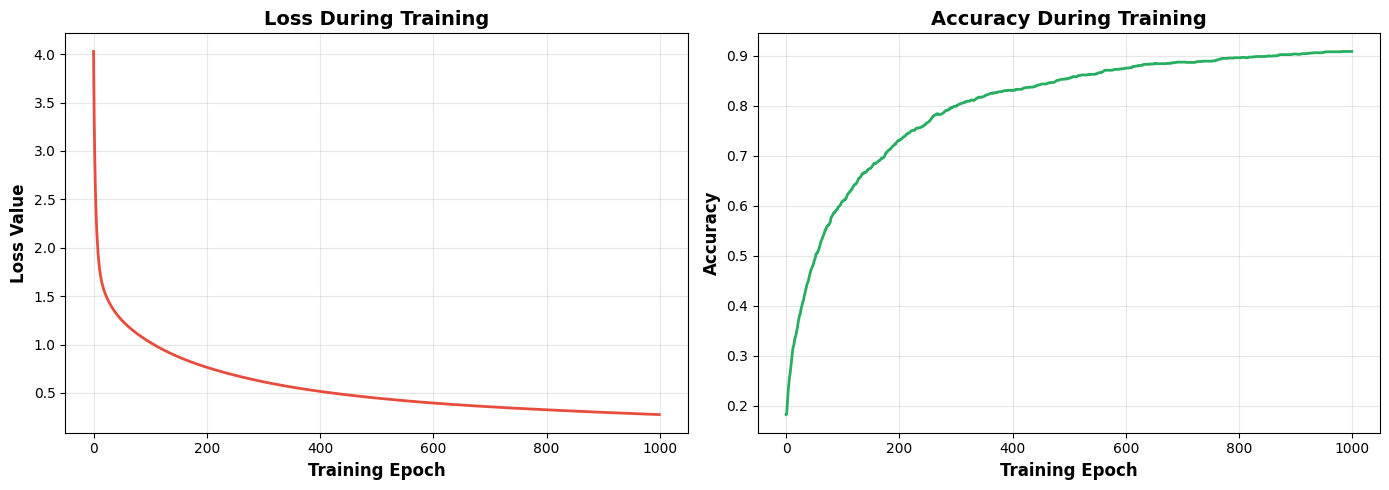

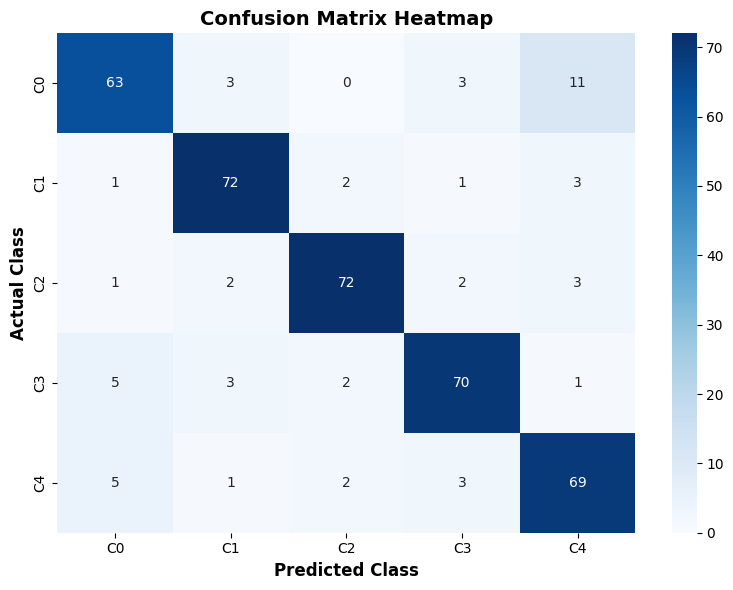

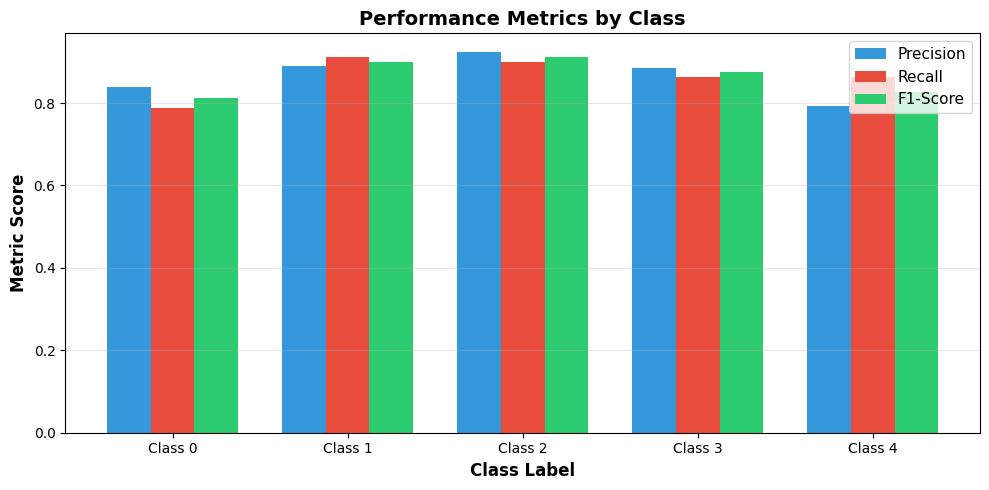

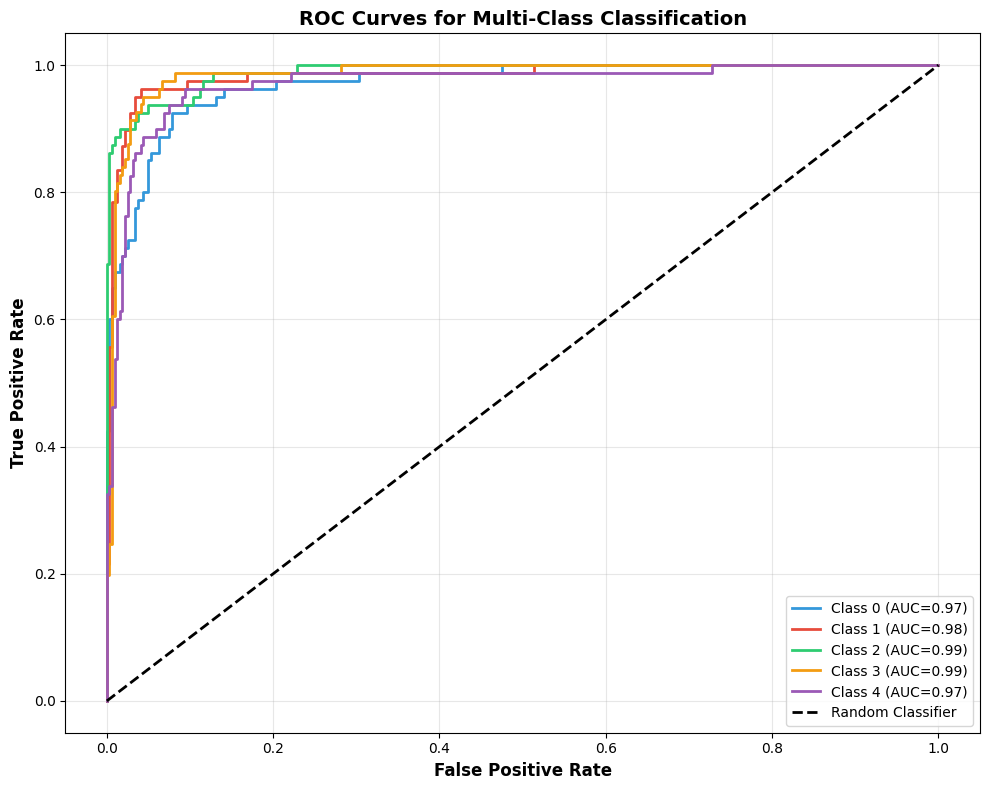

In [ ]:
# ============================================================================
# SECTION 5: VISUALIZATION
# ============================================================================

print("*" * 70)
print("SECTION 4: RESULTS VISUALIZATION")
print("*" * 70)

# Plot 1: Training Progress
figure1, (subplot1, subplot2) = plt.subplots(1, 2, figsize=(14, 5))

subplot1.plot(network.training_loss, linewidth=2, color='#E74C3C')
subplot1.set_xlabel('Training Epoch', fontsize=12, fontweight='bold')
subplot1.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
subplot1.set_title('Loss During Training', fontsize=14, fontweight='bold')
subplot1.grid(True, alpha=0.3)

subplot2.plot(network.training_accuracy, linewidth=2, color='#27AE60')
subplot2.set_xlabel('Training Epoch', fontsize=12, fontweight='bold')
subplot2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
subplot2.set_title('Accuracy During Training', fontsize=14, fontweight='bold')
subplot2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix
conf_matrix = confusion_matrix(labels_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(classes_count)],
            yticklabels=[f'C{i}' for i in range(classes_count)])
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 3: Performance Comparison
figure2, axis = plt.subplots(figsize=(10, 5))
class_indices = np.arange(classes_count)
bar_width = 0.25

bars1 = axis.bar(class_indices - bar_width, precision_scores, bar_width,
                 label='Precision', color='#3498DB')
bars2 = axis.bar(class_indices, recall_scores, bar_width,
                 label='Recall', color='#E74C3C')
bars3 = axis.bar(class_indices + bar_width, f1_scores, bar_width,
                 label='F1-Score', color='#2ECC71')

axis.set_xlabel('Class Label', fontsize=12, fontweight='bold')
axis.set_ylabel('Metric Score', fontsize=12, fontweight='bold')
axis.set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
axis.set_xticks(class_indices)
axis.set_xticklabels([f'Class {i}' for i in range(classes_count)])
axis.legend(fontsize=11)
axis.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Plot 4: ROC Curves
targets_binarized = label_binarize(labels_test, classes=range(classes_count))
false_positive_rate = {}
true_positive_rate = {}
area_under_curve = {}

plt.figure(figsize=(10, 8))
color_palette = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']

for class_id, color in enumerate(color_palette):
    false_positive_rate[class_id], true_positive_rate[class_id], _ = roc_curve(
        targets_binarized[:, class_id],
        predicted_probabilities[:, class_id]
    )
    area_under_curve[class_id] = auc(false_positive_rate[class_id], true_positive_rate[class_id])
    plt.plot(false_positive_rate[class_id], true_positive_rate[class_id],
             color=color, lw=2,
             label=f'Class {class_id} (AUC={area_under_curve[class_id]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves for Multi-Class Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 6: ANALYSIS AND DISCUSSION
# ============================================================================

print("\n" + "*" * 70)
print("SECTION 6: ANALYSIS AND INSIGHTS")
print("*" * 70)

print("\n1. Model Performance Summary:")
print(f" → Overall accuracy: {test_accuracy*100:.2f}%")
print(f" → Macro F1-score: {f1_avg:.4f}")
print(f" → Best performing class: Class {np.argmax(f1_scores)} (F1={f1_scores.max():.4f})")
print(f" → Lowest performing class: Class {np.argmin(f1_scores)} (F1={f1_scores.min():.4f})")

print("\n2. Network Architecture Analysis:")
print(" → Successfully implemented 3 hidden layers")
print(" → Layer configuration: 64 → 32 → 16 (decreasing pattern)")
print(" → ReLU activation mitigates vanishing gradient problem")
print(" → Softmax ensures valid probability distribution at output")

print("\n3. Implementation Challenges Addressed:")
print(" → He initialization used for optimal weight initialization")
print(" → Numerical stability ensured in softmax computation")
print(" → Efficient gradient computation for softmax + cross-entropy")

print("\n4. Potential Enhancement Strategies:")
print(" → Incorporate dropout layers for regularization")
print(" → Utilize advanced optimizers (Adam, RMSprop)")
print(" → Apply learning rate scheduling")
print(" → Experiment with batch normalization")

print("\n" + "*" * 70)
print("ANALYSIS COMPLETE")
print("*" * 70)



**********************************************************************
SECTION 6: ANALYSIS AND INSIGHTS
**********************************************************************

1. Model Performance Summary:
 → Overall accuracy: 86.50%
 → Macro F1-score: 0.8651
 → Best performing class: Class 2 (F1=0.9114)
 → Lowest performing class: Class 0 (F1=0.8129)

2. Network Architecture Analysis:
 → Successfully implemented 3 hidden layers
 → Layer configuration: 64 → 32 → 16 (decreasing pattern)
 → ReLU activation mitigates vanishing gradient problem
 → Softmax ensures valid probability distribution at output

3. Implementation Challenges Addressed:
 → He initialization used for optimal weight initialization
 → Numerical stability ensured in softmax computation
 → Efficient gradient computation for softmax + cross-entropy

4. Potential Enhancement Strategies:
 → Incorporate dropout layers for regularization
 → Utilize advanced optimizers (Adam, RMSprop)
 → Apply learning rate scheduling
 → Expe